In [4]:
from scipy.stats import qmc
import pandas as pd
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import shutil
import os
from sklearn.metrics import mean_squared_error
from math import sqrt
import subprocess
import warnings
import scienceplots
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

import geopandas as gpd
from matplotlib.colors import ListedColormap
import contextily as ctx
import matplotlib.colors as mcolors
warnings.filterwarnings("ignore")

C:\Users\RIPHAWK\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\RIPHAWK\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [5]:
def get_shade(run_folder):
    base_source_folder = run_folder
    control_file = pd.read_csv(os.path.join(base_source_folder, 'HeatSource_Control.csv'))

    cc_start = control_file.loc[7]['VALUE']
    cc_start = pd.to_datetime(cc_start)
    cc_end = control_file.loc[8]['VALUE']
    cc_end = pd.to_datetime(cc_end)

    shade_df = pd.read_csv(os.path.join(base_source_folder, 'outputs', 'Shade.csv'), skiprows=6, usecols=range(1, 185))
    hourly_index = pd.date_range(start=cc_start, end=cc_end + pd.DateOffset(1), freq='D', inclusive='left')  # Closed left ensures end date is exclusive




    shade_df.columns = [float(col) for col in shade_df.columns]
    shade_df.index = hourly_index
    shade = shade_df.mean()
    shade = pd.DataFrame(shade)
    shade.rename(columns={0 : 'Eff Shade'}, inplace=True)

    
    return shade

In [38]:
observed = get_shade(r'D:\Ben_wd\THESIS\heatsource\WestFork\ModelRuns\Hayes\scenarios\thesis_scenarios\July_monthly')
all_grass = get_shade(f"D:\\Ben_wd\\THESIS\\heatsource\WestFork\\ModelRuns\\Hayes\\scenarios\\thesis_scenarios\\all_grass\\grassallnodes" )
all_trees = get_shade(r'D:/Ben_wd/THESIS/heatsource/WestFork/ModelRuns/Hayes/scenarios/thesis_scenarios/all_shade/shadeallnodes')
test_grass = get_shade(r'D:\Ben_wd\THESIS\heatsource\WestFork\ModelRuns\Hayes\scenarios\thesis_scenarios\results\ModelBaselines\test')

In [36]:
test_grass

,Eff Shade
27.2,0.2206
27.1,0.1203
27.0,0.1816
26.9,0.0644
26.8,0.0628
...,...
9.3,0.0400
9.2,0.0617
9.1,0.0421
9.0,0.0515


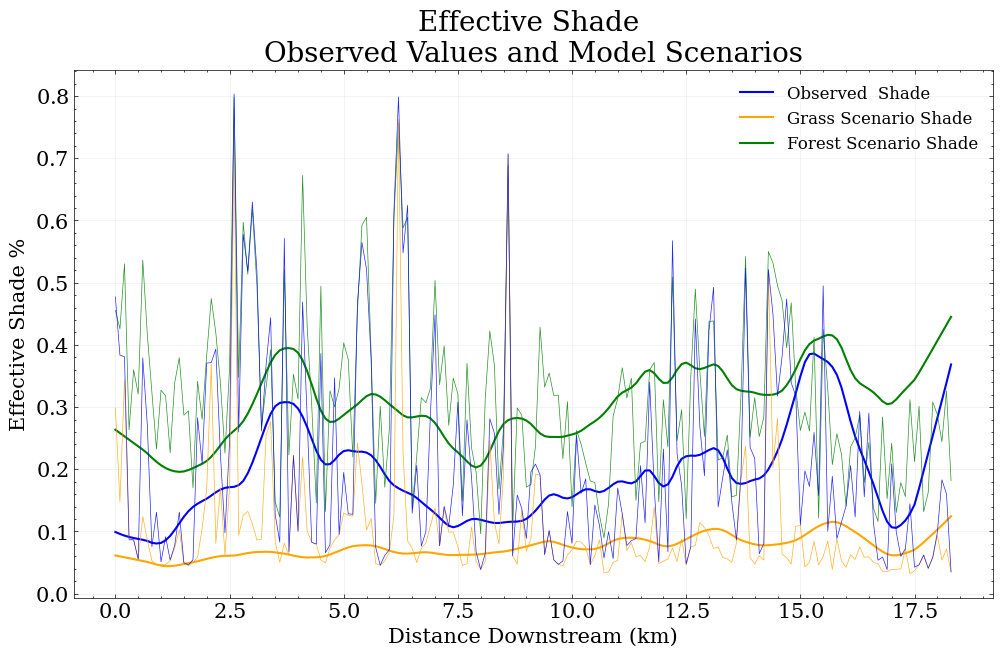

In [40]:

# Applying LOESS smoothing
smoothed_observed = lowess(observed['Eff Shade'], observed.index, frac=0.1)
smoothed_grass = lowess(all_grass['Eff Shade'], all_grass.index, frac=0.1)
smoothed_forested = lowess(all_trees['Eff Shade'], all_trees.index, frac=0.1)


# Creating a DataFrame for smoothed data
smoothed_observed = pd.DataFrame(smoothed_observed[:, 1], index=observed.index, columns=['Smoothed'])
smoothed_grass = pd.DataFrame(smoothed_grass[:, 1], index=all_grass.index, columns=['Smoothed'])
smoothed_forested = pd.DataFrame(smoothed_forested[:, 1], index=all_trees.index, columns=['Smoothed'])


with plt.style.context(['science', 'no-latex']):
    # Plotting original and smoothed data
    plt.figure(figsize=(10, 6))
    #plt.plot(18.3 - shade.index, shade[0], label='Original Data', color='b')
    plt.plot(18.3-smoothed_observed.index, smoothed_observed['Smoothed'], label='Observed  Shade', lw = 1.5, color='blue')
    plt.plot(18.3-smoothed_grass.index, smoothed_grass['Smoothed'], label='Grass Scenario Shade', lw = 1.5, color='orange')
    plt.plot(18.3-smoothed_forested.index, smoothed_forested['Smoothed'], label='Forest Scenario Shade', lw= 1.5, color='green')
    plt.plot(18.3-all_trees.index, all_trees['Eff Shade'], color='green', alpha=.85, lw = .5)#, alpha=.5)
    plt.plot(18.3-all_grass.index, all_grass['Eff Shade'], color='orange', alpha=.85, lw = .5)#, alpha=.5
    #plt.plot(27.2 - test_grass.index, test_grass['Eff Shade'], color='black', alpha=.85, lw = .5)#, alpha=.5)

    plt.plot(18.3-observed.index, observed['Eff Shade'], color='blue',lw = .5, alpha=.85)


    
    plt.ylabel('Effective Shade % (c)', size = 15)
    plt.xlabel('Distance Downstream', size = 15)
    #plt.figure(facecolor='black')

        # Adjust layout
    plt.tight_layout()
    plt.grid(alpha = .2)
    plt.yticks(size= 15)
    plt.xticks(size= 15)
    plt.xlabel('Distance Downstream (km)')
    plt.ylabel('Effective Shade %')
    #plt.vlines(trib_dict_downstream, ymin = 20, ymax = 25, label = 'Tribs',color = 'Orange', linestyles = 'dashed')
    plt.legend(loc = 'upper right', fontsize = 12)
    plt.title('Effective Shade \nObserved Values and Model Scenarios', size = 20)


plt.savefig(r'D:\Ben_wd\THESIS\figs\Thesis\Effective Shade Comparison.png', bbox_inches='tight', dpi=300)
plt.show()
